<a href="https://colab.research.google.com/github/TheophilusG/DataBootcamp/blob/main/time_series_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grid Searching and Time Series Forecasting

Use the data below to set up a `Pipeline` that one hot encodes all categorical features and builds a `RandomForestClassifier` model.  Grid search the model for an appropriate `n_estimators` and `max_depth` parameter optimizing precision.  What were the parameters of the best model?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
insurance = fetch_openml(data_id=45064)

In [4]:
insurance.frame.head()

,Upper_Age,Lower_Age,Reco_Policy_Premium,City_Code,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,class
0,52,52,16200.0,C2,Owned,Individual,No,X4,6.0,4.0,0
1,67,67,16900.0,C17,Rented,Individual,No,X1,7.0,3.0,1
2,75,75,25668.0,C10,Owned,Individual,No,X3,3.0,1.0,0
3,60,57,17586.8,C26,Owned,Joint,Yes,X1,14+,1.0,0
4,35,35,12762.0,C12,Rented,Individual,No,X1,3.0,2.0,0


In [5]:
insurance.frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23548 entries, 0 to 23547
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Upper_Age                23548 non-null  int64   
 1   Lower_Age                23548 non-null  int64   
 2   Reco_Policy_Premium      23548 non-null  float64 
 3   City_Code                23548 non-null  category
 4   Accomodation_Type        23548 non-null  category
 5   Reco_Insurance_Type      23548 non-null  category
 6   Is_Spouse                23548 non-null  category
 7   Health Indicator         23548 non-null  category
 8   Holding_Policy_Duration  23548 non-null  category
 9   Holding_Policy_Type      23548 non-null  category
 10  class                    23548 non-null  int64   
dtypes: category(7), float64(1), int64(3)
memory usage: 899.9 KB


In [6]:
insurance.frame.describe()

,Upper_Age,Lower_Age,Reco_Policy_Premium,class
count,23548.000000,23548.000000,23548.000000,23548.000000
mean,48.864192,46.365381,15409.000161,0.242059
std,16.021466,16.578403,6416.327319,0.428339
min,21.000000,16.000000,3216.000000,0.000000
25%,35.000000,32.000000,10704.000000,0.000000
50%,49.000000,46.000000,14580.000000,0.000000
75%,62.000000,60.000000,19140.000000,0.000000
max,75.000000,75.000000,43350.400000,1.000000


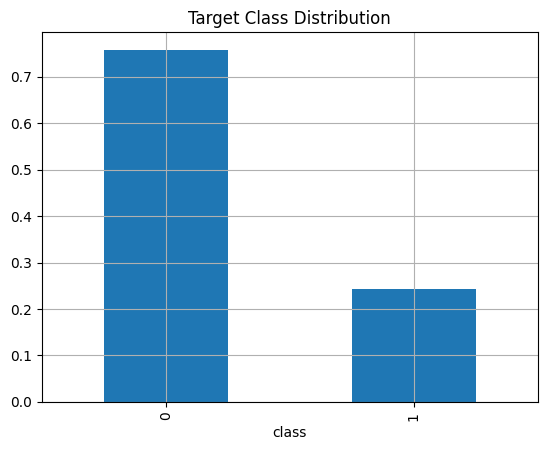

In [7]:
insurance.frame['class'].value_counts(normalize = True).plot(kind = 'bar', grid = True, title = 'Target Class Distribution');

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

In [9]:
X = insurance.frame.drop('class', axis=1)
y = insurance.frame['class']

In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
cat_columns = X.select_dtypes(include=['category']).columns
num_columns = X.select_dtypes(include=['int64', 'float64']).columns

In [12]:
# Create column transformer for preprocessing
preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), cat_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

In [25]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [26]:
# parameters for grid search
param_grid = {
    'classifier__n_estimators': [50, 100],  # Fewer options
    'classifier__max_depth': [None, 10]     # Fewer options
}


In [27]:
# grid search with precision scoring
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='precision',
    n_jobs=-1  # Uses all CPU cores
)


# Fit the grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type'],
      dtype='object')),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         Index(['Upper_Age', 'Lower_Age', 'Reco_Policy_Premium'], dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10],
                         'classifier__n_estimators': [50, 100]},
             scoring='precision')

In [28]:
from sklearn.metrics import precision_score
print("Best Parameters:", grid_search.best_params_)
print("Best Precision Score:", grid_search.best_score_)

# Predict on test set and calculate precision
y_pred = grid_search.predict(X_test)
test_precision = precision_score(y_test, y_pred)
print("Test Set Precision:", test_precision)

Best Parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
Best Precision Score: 0.230186087173723
Test Set Precision: 0.2356687898089172


### Time Series

For these problems I will reference Hyndman's [*Forecasting: Principles and Practice*](https://otexts.com/fpp3/).  At a minimum, skim chapter 8.1 - 8.4 on Exponential Smoothing methods and 9.1 - 9.5 and 9.9 on ARIMA models.  We will replicate some examples and problems from the text using `sktime`.  Reference the documentation [here](https://www.sktime.net/en/stable/index.html) when needed.



In [29]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 8.3 MB/s eta 0:00:00


In [30]:
import sktime as skt
from sktime.utils.plotting import plot_correlations, plot_series

**PROBLEM**

In 8.1, a simple exponential smoothing model is applied to the algerian export data, and a forecast is made for 5 time steps.  Use `sktime` and the `global_economy` data below to replicate this and evaluate the mean absolute percent error.  

In [31]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

In [32]:
global_economy = pd.read_csv('https://raw.githubusercontent.com/jfkoehler/nyu_bootcamp_fa24/refs/heads/main/data/global_economy.csv', index_col = 0)

In [33]:
algeria = global_economy.loc[global_economy['Country'] == 'Algeria']

In [34]:
algeria.head(3)

,Country,Code,Year,GDP,Growth,CPI,Imports,Exports,Population
117,Algeria,DZA,1960,2.723649e+09,NaN,NaN,67.143632,39.043173,11124888.0
118,Algeria,DZA,1961,2.434777e+09,-13.605441,NaN,67.503771,46.244557,11404859.0
119,Algeria,DZA,1962,2.001469e+09,-19.685042,NaN,20.818647,19.793873,11690153.0


In [41]:
# Convert to sktime compatible format
from sktime.datatypes import convert

algeria_exports = algeria['Exports']

# NaN values dropping
algeria_exports = algeria_exports.dropna()

# Forecast using Exponential Smoothing
forecaster = ExponentialSmoothing()
forecaster.fit(algeria_exports)

# Make forecast for next 5 steps
fh = np.arange(1, 6)  # forecast horizon
forecast = forecaster.predict(fh)

In [42]:
#Mean Absolute Percentage Error
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError()
print("Forecast:", forecast)
actual_values_for_forecast = algeria_exports.tail(len(forecast))
print("MAPE:", mape(actual_values_for_forecast, forecast))

Forecast: 175    22.444596
176    22.444596
177    22.444596
178    22.444596
179    22.444596
Name: Exports, dtype: float64
MAPE: 0.139471657306763


**PROBLEM**

Use the data on the Australian population to replicate the exponential smoothing model with a trend from 8.2 [here](https://otexts.com/fpp3/holt.html#example-australian-population).

In [40]:
aus_economy = global_economy.loc[global_economy['Country'] == 'Australia']

In [43]:
aus_population = aus_economy['Population']

# Dropping NaN values
aus_population = aus_population.dropna()

In [44]:
# Forecast using Exponential Smoothing with Trend
forecaster = ExponentialSmoothing(trend='add')
forecaster.fit(aus_population)

# Make forecast for next 5 steps
fh = np.arange(1, 6)  # forecast horizon
forecast = forecaster.predict(fh)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [48]:
#Mean Absolute Percentage Error
mape = MeanAbsolutePercentageError()

print("Forecast:", forecast)
# Align the lengths of aus_population and forecast by using the last 'fh' (forecast horizon) values of aus_population
print("MAPE:", mape(aus_population[-len(fh):], forecast))

Forecast: 697    2.496761e+07
698    2.533643e+07
699    2.570525e+07
700    2.607406e+07
701    2.644288e+07
Name: Population, dtype: float64
MAPE: 0.07726691253724292


**PROBLEM**

Use the data below on Australian tourism to fit a Holt Winters model with additive and multiplicative seasonality.  Compare the performance using `mape` and plot the results with `plot_series`.

In [47]:
aus_tourism = pd.read_csv('https://raw.githubusercontent.com/jfkoehler/nyu_bootcamp_fa24/refs/heads/main/data/aus_holidays.csv', index_col = 0)
aus_tourism.head()

,Quarter,Trips
1,1998 Q1,11.806038
2,1998 Q2,9.275662
3,1998 Q3,8.642489
4,1998 Q4,9.299524
5,1999 Q1,11.172027


In [55]:
aus_tourism['Quarter'] = pd.to_datetime(aus_tourism['Quarter'].str.replace(' ', ''), format='%YQ%m')
#The format code '%q' is invalid. We replace it with '%m' to extract the month.
#Since the data is quarterly, the month can represent the quarter (e.g., 3 for Q1, 6 for Q2, 9 for Q3, 12 for Q4).
#Later, if you need to work with quarters, you might need to extract that information separately and assign it to a new column.

aus_tourism.set_index('Quarter', inplace=True)

In [58]:
# Set the frequency of the index to quarterly
aus_tourism = aus_tourism.asfreq('Q', method='ffill')

# Additive Seasonality Model
forecaster_add = ExponentialSmoothing(seasonal='add', sp=4)  # Quarterly data
forecaster_add.fit(aus_tourism['Trips'])
forecast_add = forecaster_add.predict(fh=5)

In [60]:
# Multiplicative Seasonality Model
forecaster_mult = ExponentialSmoothing(seasonal='multiplicative', sp=4)  # Quarterly data # Changed 'mult' to 'multiplicative'
forecaster_mult.fit(aus_tourism['Trips'])
forecast_mult = forecaster_mult.predict(fh=5)

Additive Model MAPE: 0.009713653942052237
Multiplicative Model MAPE: 0.011373568366598382


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Trips'>)

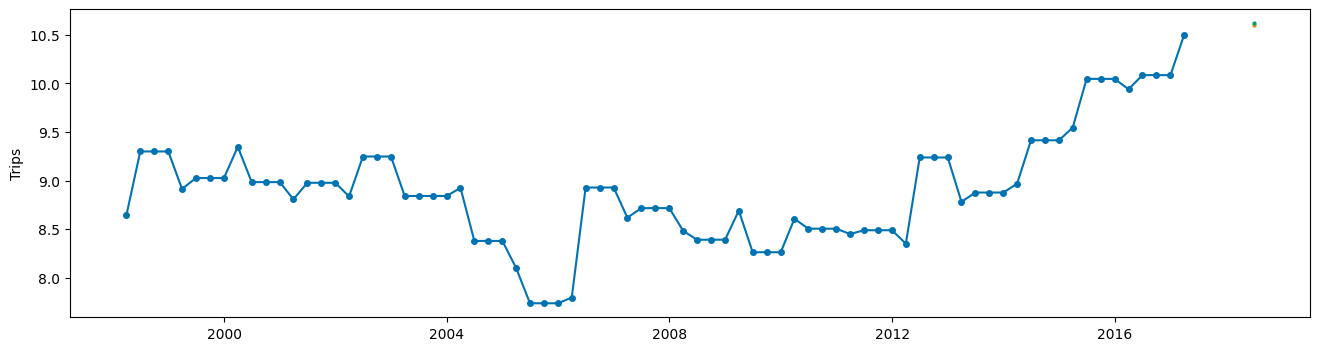

In [62]:
# Performance Metrics
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

mape = MeanAbsolutePercentageError()

# Get the last len(forecast_add) values from aus_tourism['Trips'] for comparison
# This ensures both series have the same number of rows
actual_values_add = aus_tourism['Trips'][-len(forecast_add):]
actual_values_mult = aus_tourism['Trips'][-len(forecast_mult):]

print("Additive Model MAPE:", mape(actual_values_add, forecast_add))
print("Multiplicative Model MAPE:", mape(actual_values_mult, forecast_mult))

# Plot results
from sktime.utils.plotting import plot_series
plot_series(aus_tourism['Trips'], forecast_add, forecast_mult)

**PROBLEM**

An example of non-stationary data are stock prices.  Use the stock dataset below to plot the daily closing price for Amazon.  Use differencing to make the series stationary and compare the resulting autocorrelation plots.

In [63]:
stocks = pd.read_csv('https://raw.githubusercontent.com/jfkoehler/nyu_bootcamp_fa24/refs/heads/main/data/gafa_stock.csv', index_col = 0)
stocks.head()

,Symbol,Date,Open,High,Low,Close,Adj_Close,Volume
1,AAPL,2014-01-02,79.382858,79.575714,78.860001,79.018570,66.964325,58671200.0
2,AAPL,2014-01-03,78.980003,79.099998,77.204285,77.282860,65.493416,98116900.0
3,AAPL,2014-01-06,76.778572,78.114288,76.228569,77.704285,65.850533,103152700.0
4,AAPL,2014-01-07,77.760002,77.994286,76.845711,77.148575,65.379593,79302300.0
5,AAPL,2014-01-08,76.972855,77.937141,76.955711,77.637146,65.793633,64632400.0


<Axes: title={'center': 'Amazon Daily Closing Price'}>

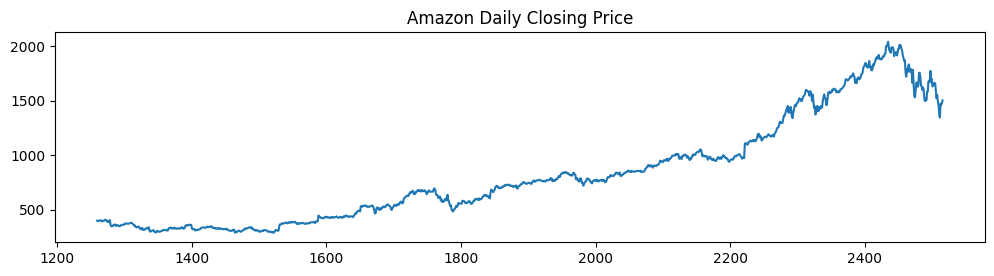

In [64]:
amazon_prices = stocks.loc[stocks['Symbol'] == 'AMZN', 'Close']

# Plot original series
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.title('Amazon Daily Closing Price')
amazon_prices.plot()

In [65]:
# First differencing
amazon_diff = amazon_prices.diff().dropna()

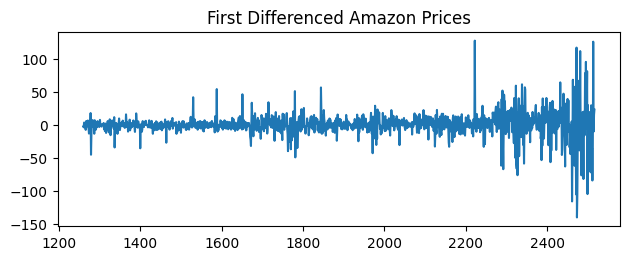

In [66]:
# Plot differenced series
plt.subplot(2, 1, 2)
plt.title('First Differenced Amazon Prices')
amazon_diff.plot()

plt.tight_layout()

In [69]:
!pip install statsmodels

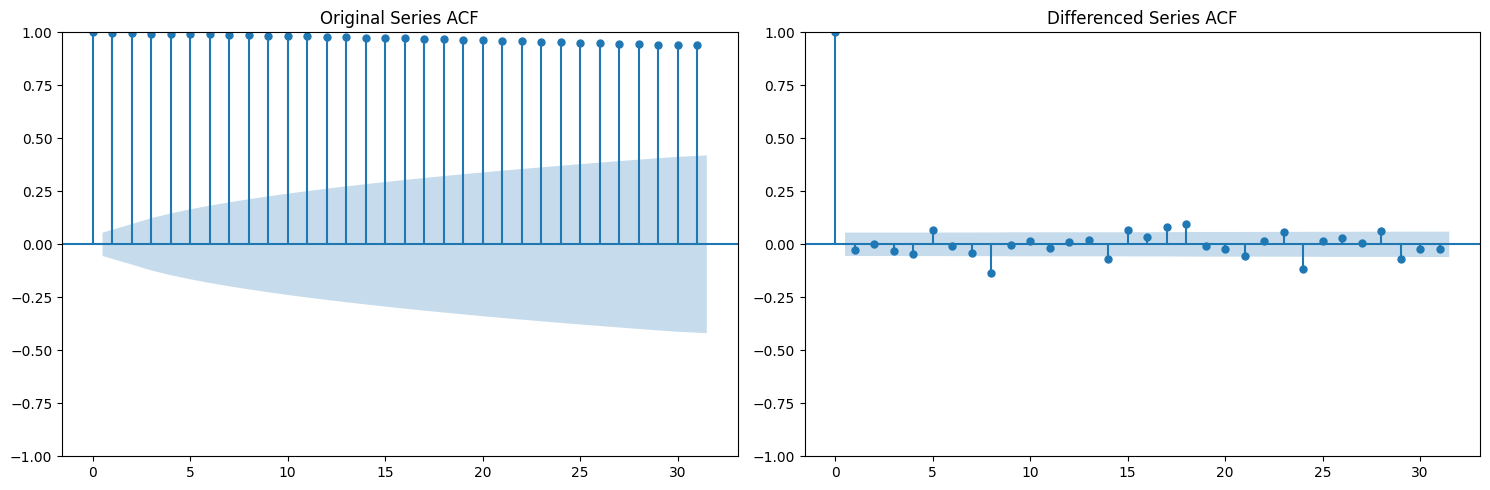

In [70]:
# Autocorrelation plots
import statsmodels.api as sm
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sm.graphics.tsa.plot_acf(amazon_prices, ax=ax1, title='Original Series ACF')
sm.graphics.tsa.plot_acf(amazon_diff, ax=ax2, title='Differenced Series ACF')

plt.tight_layout()
plt.show()

**PROBLEM**

Use the data on australian air passengers below to fit an `AutoARIMA` model with `sktime`.  What parameters were chosen?  Plot the model and evaluate its predictions on 10 time steps.

In [71]:
aus_air = pd.read_csv('https://raw.githubusercontent.com/jfkoehler/nyu_bootcamp_fa24/refs/heads/main/data/aus_air.csv', index_col = 0)
aus_air.head()

,Year,Passengers
1,1970,7.3187
2,1971,7.3266
3,1972,7.7956
4,1973,9.3846
5,1974,10.6647


In [73]:
!pip install pmdarima
from pmdarima import AutoARIMA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.3 MB/s eta 0:00:00


In [74]:
forecaster = AutoARIMA()
forecaster.fit(aus_air['Passengers'])

AutoARIMA()

In [76]:
# Forecast next 10 steps
fh = np.arange(1, 11)
forecast = forecaster.predict(n_periods=10)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [77]:
# Performance metrics
mape = MeanAbsolutePercentageError()

In [80]:
actual_values = aus_air['Passengers'].tail(len(forecast))  # Get the last 10 values of 'Passengers'

# Calculate MAPE using the actual values for the forecasted period
print("MAPE:", mape(actual_values, forecast))

# Model parameters
print("Best ARIMA Parameters:", forecaster.model_.get_params())

MAPE: 0.37984281704674494
Best ARIMA Parameters: {'maxiter': 50, 'method': 'lbfgs', 'order': (0, 2, 1), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Passengers'>)

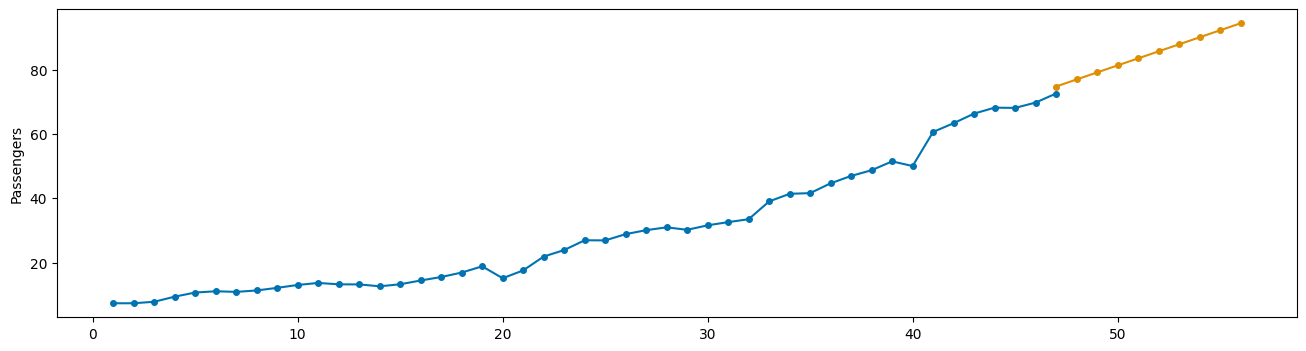

In [81]:
# Plot results
plot_series(aus_air['Passengers'], forecast)